# Story 3

*Do stricter gun laws reduce firearm gun deaths?*

In [1]:
import requests
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium


## Datasources

We can use the below NCHS API endpoint to see cause of death rates per state *per quarter* in the US. This will be a good starting point as we look to visualize per state

- [NCHS Leading Cause of Deathe API Endpoint](https://dev.socrata.com/foundry/data.cdc.gov/bi63-dtpu)

In [4]:
# Grabbing data from API endpoint
response = requests.get("https://data.cdc.gov/resource/489q-934x.json").json()

In [5]:
# Write response to pandas dataframe
df = pd.json_normalize(response)
df.head()

,year_and_quarter,time_period,cause_of_death,rate_type,unit,rate_overall,rate_sex_female,rate_sex_male,rate_alaska,rate_alabama,...,rate_age_1_4,rate_age_5_14,rate_age_15_24,rate_age_25_34,rate_age_35_44,rate_age_45_54,rate_age_55_64,rate_65_74,rate_age_75_84,rate_age_85_plus
0,2022 Q1,12 months ending with quarter,All causes,Age-adjusted,"Deaths per 100,000",873.2,729.4,1038,944.5,1109.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022 Q1,12 months ending with quarter,Alzheimer disease,Age-adjusted,"Deaths per 100,000",30.6,35,23.8,28.5,45.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022 Q1,12 months ending with quarter,COVID-19,Age-adjusted,"Deaths per 100,000",95,75.2,119.1,121.3,133.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2022 Q1,12 months ending with quarter,Cancer,Age-adjusted,"Deaths per 100,000",145.9,127.4,170.9,156,159.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2022 Q1,12 months ending with quarter,Chronic liver disease and cirrhosis,Age-adjusted,"Deaths per 100,000",14.4,10.3,18.9,25.5,16.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Wrangling

In [6]:
# Pulling out only firearm deaths that are age-adjusted
df = df.loc[(df.cause_of_death == "Firearm-related injury") & (df.rate_type == "Age-adjusted") & (df.time_period=="3-month period")]

In [7]:
# Select only needed columns and transpose our data
state_cols = ['year_and_quarter', 'rate_alaska', 'rate_alabama', 'rate_arkansas', 'rate_arizona',
              'rate_california', 'rate_colorado', 'rate_connecticut',
              'rate_district_of_columbia', 'rate_delaware', 'rate_florida',
              'rate_georgia', 'rate_hawaii', 'rate_iowa', 'rate_idaho',
              'rate_illinois', 'rate_indiana', 'rate_kansas', 'rate_kentucky',
              'rate_louisiana', 'rate_massachusetts', 'rate_maryland', 'rate_maine',
              'rate_michigan', 'rate_minnesota', 'rate_missouri', 'rate_mississippi',
              'rate_montana', 'rate_north_carolina', 'rate_north_dakota',
              'rate_nebraska', 'rate_new_hampshire', 'rate_new_jersey',
              'rate_new_mexico', 'rate_nevada', 'rate_new_york', 'rate_ohio',
              'rate_oklahoma', 'rate_oregon', 'rate_pennsylvania',
              'rate_rhode_island', 'rate_south_carolina', 'rate_south_dakota',
              'rate_tennessee', 'rate_texas', 'rate_utah', 'rate_virginia',
              'rate_vermont', 'rate_washington', 'rate_wisconsin',
              'rate_west_virginia', 'rate_wyoming', 'rate_overall']
df = df[state_cols].transpose()
df.head()

,31,75,119,163,207,251,295,339,383
year_and_quarter,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
rate_alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
rate_alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
rate_arkansas,19.1,25,23.4,20,22.7,23.3,21.9,19.6,NaN
rate_arizona,18.6,22.6,20.7,18.6,18,18.3,18.9,18.8,NaN


In [8]:
# Clean up column names and types
df.columns = df.iloc[0]


In [9]:
# Clean up state names and set index
df["state"] = [s.replace("_", " ").replace("rate", "").title().strip() for s in df.index.values]
df = df.set_index('state')
df.head()

year_and_quarter,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
state,,,,,,,,,
Year And Quarter,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
Alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
Alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
Arkansas,19.1,25,23.4,20,22.7,23.3,21.9,19.6,NaN
Arizona,18.6,22.6,20.7,18.6,18,18.3,18.9,18.8,NaN


In [11]:
# Enforcing typing on state names
df["state"] = df["state"].str.title().astype(str)

# Iterate only over existing columns for type conversion
for c in ['2022 Q1', '2022 Q2', '2022 Q3', '2022 Q4', '2023 Q1',
          '2023 Q2', '2023 Q3', '2023 Q4', '2024 Q1', '2024 Q2',
          '2024 Q3', '2024 Q4']:
    if c in df.columns:
        df[c] = df[c].astype(float)

df.head()

year_and_quarter,state,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
1,Alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
2,Alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
3,Arkansas,19.1,25.0,23.4,20.0,22.7,23.3,21.9,19.6,NaN
4,Arizona,18.6,22.6,20.7,18.6,18.0,18.3,18.9,18.8,NaN
5,California,8.3,8.9,9.4,7.9,8.1,7.7,8.4,7.4,NaN


## Data Visualization
Let's first plot the rate of firearm related homo

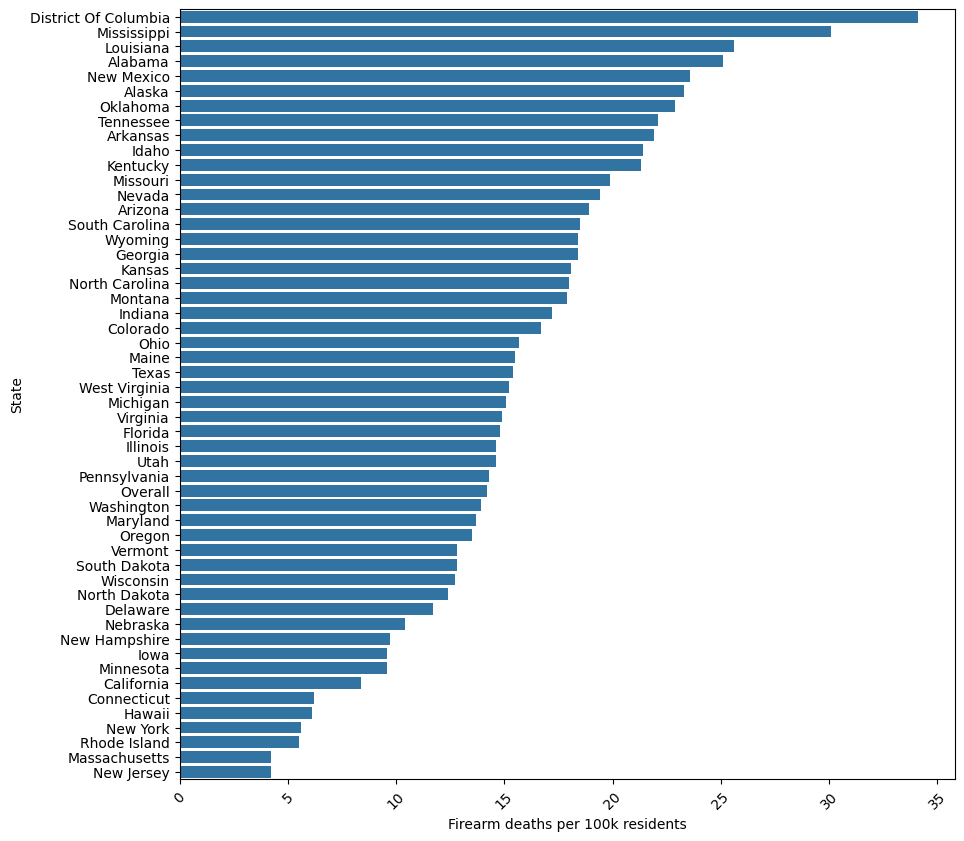

In [12]:
df_sorted = df.sort_values("2023 Q3", ascending=False)
order = df.groupby("state").sum().sort_values(['2023 Q3'], ascending=False).index

# Plot a sorted bar chart of deaths per 100k
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(data=df, x="2023 Q3", y="state", order=order, orient="h")
ax.set_xlabel("Firearm deaths per 100k residents")
ax.set_ylabel("State")
plt.xticks(rotation=45)

plt.show()

In [15]:
# Load the firearm mortality data from CSV
df_firearm_mortality = pd.read_csv('https://raw.githubusercontent.com/waheeb123/Datasets/refs/heads/main/data-table.csv')

# Check the structure of the data
df_firearm_mortality.head()


,YEAR,STATE,RATE,DEATHS,URL
0,2022,AL,25.5,"1,278",/nchs/pressroom/states/alabama/al.htm
1,2022,AK,22.4,164,/nchs/pressroom/states/alaska/ak.htm
2,2022,AZ,20.1,"1,535",/nchs/pressroom/states/arizona/az.htm
3,2022,AR,21.9,666,/nchs/pressroom/states/arkansas/ar.htm
4,2022,CA,8.6,"3,484",/nchs/pressroom/states/california/ca.htm


In [19]:
# Convert to geopandas dataframe
gdf = gpd.GeoDataFrame(df)

gdf.head()

year_and_quarter,state,2022 Q1,2022 Q2,2022 Q3,2022 Q4,2023 Q1,2023 Q2,2023 Q3,2023 Q4,2024 Q1
1,Alaska,22.8,20.2,24.4,22.3,18.7,24.4,23.3,27.6,NaN
2,Alabama,24.1,26.7,27.7,23.5,27.9,25.7,25.1,23.6,NaN
3,Arkansas,19.1,25.0,23.4,20.0,22.7,23.3,21.9,19.6,NaN
4,Arizona,18.6,22.6,20.7,18.6,18.0,18.3,18.9,18.8,NaN
5,California,8.3,8.9,9.4,7.9,8.1,7.7,8.4,7.4,NaN


In [20]:
# Join Firearm data to geometry data
dat = gdf.merge(states, on="state", how='left')
dat = dat.iloc[1:]
dat.head()

NameError: name 'states' is not defined

In [ ]:
# Convert types

In [ ]:
# Getting state data
state_geo = requests.get(
    "https://raw.githubusercontent.com/python-visualization/folium-example-data/main/us_states.json"
).json()

We can use [Folium's `choropleth` function](https://python-visualization.github.io/folium/latest/getting_started.html) to make this heatmap

In [ ]:
m = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=dat,
    columns=["id", "2022 Q3"],
    key_on="feature.id",
    fill_color="YlGn",
    legend_name="Firearm Deaths per 100k inhabitants",
).add_to(m)

# Add title and kicker
title_html = "<h4>Firearm Deaths per 100,000 inhabitants - USA Q3 2022</h4>"
subtitle_html = "<p>States with higher rates of firearm death tend to also have less restrictive gun laws</p>"


m.get_root().html.add_child(folium.Element(title_html)).add_child(folium.Element(subtitle_html))
m

[Giffords also posts rankings of the relative strength of state's gun laws](https://giffords.org/lawcenter/resources/scorecard/). This can be a helpful way for us to visualize where gun laws are more or less restrictvie in the US, which can help us to answer the question of whether they correlate with a state's gun death rate.

In [ ]:
# Read in rankings
ranks = pd.read_html("https://giffords.org/lawcenter/resources/scorecard/")[0]

# Clean up relevant columns
ranks['state'] = ranks['State'].astype(str)
ranks = ranks.loc[ranks['Gun Law Strength  (Ranked)'] != "Share"]
ranks['gun_law_strength_ranking'] = ranks['Gun Law Strength  (Ranked)'].astype(int)

# Merge to geographic data
ranks = gpd.GeoDataFrame(ranks).merge(states, how="left", on="state")
ranks.head()

,Gun Law Strength (Ranked),State,Grade,Gun Death Rate (Ranked),Gun Death Rate (per 100K),state,gun_law_strength_ranking,id,name,geometry
0,38,Alabama,F,4,26.4,Alabama,38,AL,Alabama,"POLYGON ((-87.35930 35.00118, -85.60667 34.984..."
1,41,Alaska,F,6,25.2,Alaska,41,AK,Alaska,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691..."
2,42,Arizona,F,17,18.3,Arizona,42,AZ,Arizona,"POLYGON ((-109.04250 37.00026, -109.04798 31.3..."
3,50,Arkansas,F,8,23.3,Arkansas,50,AR,Arkansas,"POLYGON ((-94.47384 36.50186, -90.15254 36.496..."
4,1,California,A,43,9.0,California,1,CA,California,"POLYGON ((-123.23326 42.00619, -122.37885 42.0..."


In [ ]:
# Plotting gun law strength
m1 = folium.Map(location=[48, -102], zoom_start=3)
folium.Choropleth(
    geo_data=state_geo,
    name="choropleth",
    data=ranks,
    columns=["id", "gun_law_strength_ranking"],
    key_on="feature.id",
    fill_color="YlGn",
    legend_name="Gun Law Strength Ranking",
).add_to(m1)

# Add title and kicker
title_html = '''
             <h4>Gun Law Ratings per state (Giffords)</h4>
             '''
subtitle_html = "<p>States with stronger gun laws tend to have fewer firearm deaths per capita.</p>"


m1.get_root().html.add_child(folium.Element(title_html)).add_child(folium.Element(subtitle_html))

m1

We can see states with higher rankings (lighter shades such as California, New York, etc.) on the above choropleth also tend to have lower death rates from firearms. So there is some weight to the theory of stricter gun laws can have a positive impact on lowering firearm-related deaths

### Likert Scale
We can create a [5-point Likert Scale](https://www.simplypsychology.org/likert-scale.html) in order to

In [ ]:
# COllapse grades into 5 bins
ranks['grade'] = ranks['Grade'].str.replace("+", "")
ranks['grade'] = ranks['grade'].str.replace("-", "")

likert = ranks.groupby("grade")["grade"].count()
likert

grade
A     8
B     7
C     8
D     1
F    26
Name: grade, dtype: int64

Text(0, 0.5, 'Number of US States')

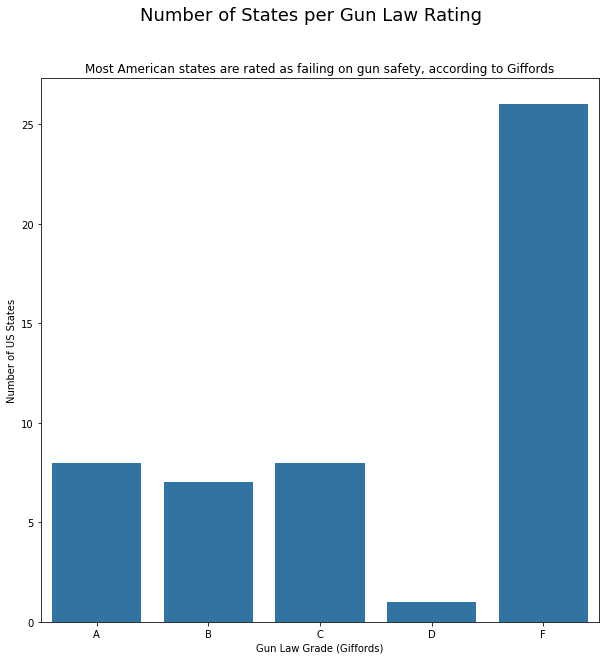

In [ ]:
f, ax = plt.subplots(figsize=(10,10))
sns.barplot(ax=ax, data=likert)

# Style the likert scale plot
plt.suptitle("Number of States per Gun Law Rating", fontsize=18)
ax.set_title("Most American states are rated as failing on gun safety, according to Giffords")
ax.set_xlabel("Gun Law Grade (Giffords)")
ax.set_ylabel("Number of US States")



## Conclusion

Unfortunately, our likert scale based on Gifford ratings shows many US States as having a "failing" record on implementing proper gun laws. We can see the longer-tail effects of these policies in the firearm death rate choropleth above, as states with looser gun laws tend to see more firearm realted injury and deaths.

Further work could include more study over time of the effects of looser gun laws, as the NCHS API endpoint used only provided data for the past 3 years.,